In [60]:
import os
import open_clip
import torch
import numpy as np
from matplotlib import pyplot as plt

from dimensionality_recuction import pca
from utils import get_dataset, get_clip_features
from classify_images import ClipClassifier

In [61]:
# @title settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_name = 'ViT-B-32'
# pretrained_datset = 'laion2b_s34b_b79k'
model_name = 'RN50'
pretrained_datset = 'openai'

dataset_name = "STL10"
outputs_dir = os.path.join("outputs", f"{model_name}({pretrained_datset})")

# Load_model
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_datset, device=device, cache_dir='/mnt/storage_ssd/big_files')
model.preprocess = preprocess

dataset, label_map = get_dataset(dataset_name, model.preprocess, data_root='/mnt/storage_ssd/datasets')

# Limit data to cats and dogs
subset_names = ['dog', 'cat']
subset_idx = [dataset.classes.index(x) for x in subset_names]
dataset.classes = subset_names
indices = np.logical_or(*[dataset.labels == x for x in subset_idx])
dataset.data = dataset.data[indices]
dataset.labels = dataset.labels[indices]
for new_idx, old_idx in enumerate(subset_idx):
    dataset.labels[dataset.labels == old_idx] = new_idx

classifier = ClipClassifier(model, dataset)

# Extract CLIP features
text_features, image_features, labels = get_clip_features(model, dataset, label_map, device,
                                                          os.path.join(outputs_dir, f"{dataset_name}_features"))

# PCA
PCs, eigv, mean = pca(np.concatenate((text_features, image_features)))
PCs, mean = torch.from_numpy(PCs), torch.from_numpy(mean)
text_pcs = (text_features - mean) @ PCs
image_pcs = (image_features - mean) @ PCs
# label_pcs = np.dot(classifier.label_features.cpu().numpy() - mean, PCs)

Files already downloaded and verified


/home/ariel/university/Internship/diffusion_venv/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [150]:
from torch import optim
from PIL import Image
import cv2
import torchvision

def puttext(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (128, 128, 128), 2, cv2.LINE_AA)

def typographic_atack(img, text):   
    img = img.clone().cpu().numpy().transpose((1, 2, 0))
    img = img - img.min()
    img = img / img.max()
    img = np.ascontiguousarray(img * 255, dtype=np.uint8)

    puttext(img, text, 100, 150)
    
    img = Image.fromarray(img)
    img = torchvision.transforms.ToTensor()(img)

    return img.unsqueeze(0).cuda()


def optimize_image(model, img, target_label, classifier, norm_coeff=0.01, lr=0.1, n_steps=100):
    y_goal = torch.tensor([target_label]).cuda()
    img = img.clone().cuda().unsqueeze(0)
    residue = torch.zeros_like(img)
    residue.requires_grad = True
    optimizer = optim.Adam([residue], lr=lr)

    for i in range(n_steps):
        features = model.encode_image(img + residue).float()
        features = features / features.norm(dim=-1, keepdim=True)

        logits = classifier.predict(features, return_probs=True)

        residue_norm = torch.norm(residue.view(len(residue), -1), dim=1).mean()

        loss = torch.nn.functional.nll_loss(logits, y_goal) + norm_coeff * residue_norm
        loss.backward()
        residue.grad = residue.grad.sign()
        optimizer.step()
        residue.grad.zero_()

        print(f"iter: {i}, loss: {loss.item()}, residue_norm: {residue_norm.item()}")

    return (img + residue).detach()


def pred_and_get_pcs(x):
    with torch.no_grad():
        features = model.encode_image(x)
        features /= features.norm(dim=-1, keepdim=True)
        pcs = (features.cpu() - mean) @ PCs
        pred = classifier.predict(features)
    return pcs, pred

In [154]:
img, gt_label = dataset[np.random.randint(len(dataset))]
target_label = np.random.choice([x for x in range(len(dataset.classes)) if x != gt_label])

adv_output = optimize_image(model, img, target_label, classifier, norm_coeff=0.05, lr=0.1, n_steps=100)

typo_output = typographic_atack(img, dataset.classes[target_label])

torchvision.utils.save_image(img, "outputs/img.png", normalize=True, scale_each=True)
torchvision.utils.save_image(adv_output, "outputs/adv.png", normalize=True, scale_each=True)
torchvision.utils.save_image(typo_output, "outputs/typo.png", normalize=True, scale_each=True)

img_pcs, img_pred = pred_and_get_pcs(img.cuda().unsqueeze(0))
typo_pcs, typo_pred = pred_and_get_pcs(typo_output)
adv_pcs, adv_pred = pred_and_get_pcs(adv_output)
print(f"GT label: {dataset.classes[gt_label]}, adv_pred: {dataset.classes[adv_pred.item()]}, typo_pred: {dataset.classes[typo_pred.item()]}")

iter: 0, loss: -0.490572065114975, residue_norm: 0.0
iter: 1, loss: 1.4429049491882324, residue_norm: 38.79793167114258
iter: 2, loss: 1.3671047687530518, residue_norm: 37.479366302490234
iter: 3, loss: 0.6707103252410889, residue_norm: 23.621129989624023
iter: 4, loss: 0.03775680065155029, residue_norm: 10.794745445251465
iter: 5, loss: 0.5053325295448303, residue_norm: 20.19763946533203
iter: 6, loss: 0.8416531682014465, residue_norm: 27.058265686035156
iter: 7, loss: 0.9219424724578857, residue_norm: 28.739479064941406
iter: 8, loss: 0.8201346397399902, residue_norm: 26.74000358581543
iter: 9, loss: 0.5671854019165039, residue_norm: 21.71141815185547
iter: 10, loss: 0.2718885540962219, residue_norm: 15.75605583190918
iter: 11, loss: 0.17073577642440796, residue_norm: 13.65234375
iter: 12, loss: 0.2875795364379883, residue_norm: 16.002708435058594
iter: 13, loss: 0.3915850520133972, residue_norm: 18.134281158447266
iter: 14, loss: 0.4189128875732422, residue_norm: 18.723922729492188


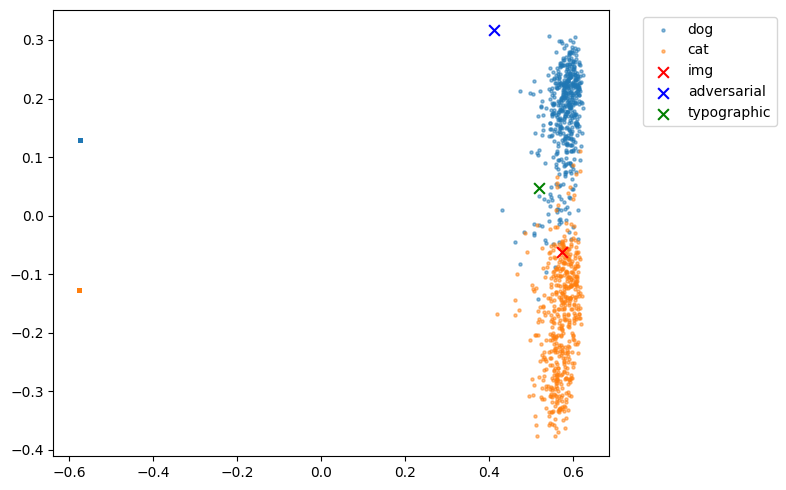

<Figure size 640x480 with 0 Axes>

In [155]:
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(dataset.classes))]
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)
pc_1 = 0
pc_2 = 1
for label in np.unique(labels):
    idx = labels == label
    ax.scatter(text_pcs[idx, pc_1], text_pcs[idx, pc_2],
               color=colors[label], label=dataset.classes[label], s=5, alpha=0.5)
    ax.scatter(image_pcs[idx, pc_1], image_pcs[idx, pc_2],
               color=colors[label], s=5, alpha=0.5)
    
ax.scatter(img_pcs[:, pc_1], img_pcs[:, pc_2],
   color='r', s=60, alpha=1, marker='x', label='img')

ax.scatter(adv_pcs[:, pc_1], adv_pcs[:, pc_2],
   color='b', s=60, alpha=1, marker='x', label='adversarial')

ax.scatter(typo_pcs[-1:, pc_1], typo_pcs[-1:, pc_2],
   color='g', s=60, alpha=1, marker='x', label='typographic')
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("outputs/fig.png")
plt.show()
plt.clf()


In [65]:
labels



array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,